In [1]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os

from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from settings import colors, titles

In [2]:
mplego.style.use_latex_style()

In [7]:
base_path = '/storage/noise_correlations/exp09'

In [8]:
ret2_path = os.path.join(base_path, 'exp09_ret2_15_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, 'exp09_1_pvc11_15_1000_1000.h5')
ecog_path = os.path.join(base_path, 'exp09_ecog_15_3000_1000.h5')

# Extra datasets
# pvc11_2_path = os.path.join(base_path, 'exp09_2_pvc11_15_1000_1000.h5')
# pvc11_3_path = os.path.join(base_path, 'exp09_3_pvc11_15_1000_1000.h5')

In [9]:
ret2 = h5py.File(ret2_path, 'r')
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

# Extra datasets
# pvc11_2 = h5py.File(pvc11_2_path, 'r')
# pvc11_3 = h5py.File(pvc11_3_path, 'r')

In [10]:
n_max_units = ret2['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)

In [24]:
groups = [
    'v_lfi',
    'v_s_lfi',
    'v_r_lfi',
    'v_fa_lfi'
]
labels = mplego.labels.bold_text([
    'Observed',
    'Shuffle',
    'Rotation',
    'FA'
])

percentile_groups = [
    'p_s_lfi',
    'p_r_lfi',
    'p_fa_lfi'
]
value_groups = [
    'v_s_lfi',
    'v_r_lfi',
    'v_fa_lfi'
]
models = [
    'shuffle',
    'rotation',
    'fa'
]
labels2 = mplego.labels.bold_text([
    'Shuffle',
    'Rotation',
    'FA'
])
titles = mplego.labels.bold_text(titles)

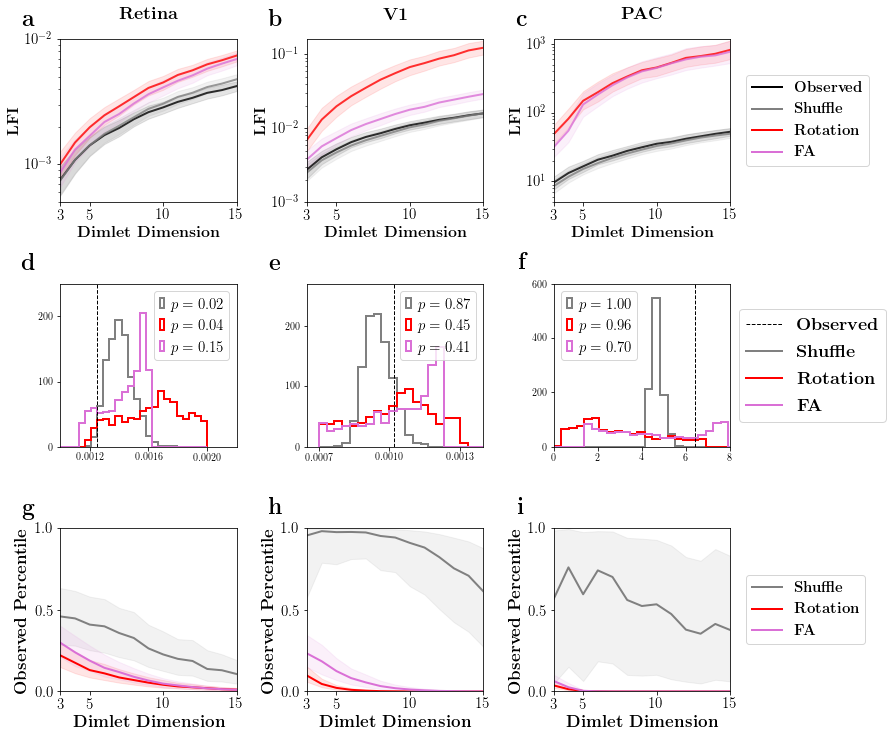

In [58]:
"""
Figure Settings
"""
# Subplot adjustments
wspace = 0.4
hspace = 0.5
title_pad = 20
# Label adjustments
subplot_label_size = 22
axis_label_size = 16
title_size = 18
subplot_x = -0.18
subplot_y = 1.12
# Line settings
linewidth = 2
line_alpha = 0.8
# Fill settings
fill_alpha = 0.1
# Legend settings
legend_size = 15
outer_legend_size = 18
handlelength = 0.3
handletextpad = 0.4
# Font sizes
label_font_size = 17
tick_font_size = 15
subplot_label_size = 23
# Percentile bounds for curves
percentile_lower = 40
percentile_upper = 60
bins = [
    np.linspace(0.0010, 0.002, 25),
    np.linspace(0.0007, 0.0015, 25),
    np.linspace(0, 10, 30)
]
"""
Figure 3
"""
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
plt.subplots_adjust(wspace=wspace, hspace=hspace)

# Enumerate over results
for idx, (result, ax) in enumerate(zip(results, axes[0])):
    # Plot observed LFI
    for group, color in zip(groups, colors.values()):
        if group == 'v_lfi':
            values = result[group][:]
        else:
            values = np.median(result[group], axis=2)
            # Alternative: take statistics across all dim-stims and repeats
            # values = np.reshape(result[group], (dims.size, -1))
        median = np.median(values, axis=1)
        lower = np.percentile(values, q=percentile_lower, axis=1)
        upper = np.percentile(values, q=percentile_upper, axis=1)
        # Fill region between percentile bounds
        ax.fill_between(
            x=dims,
            y1=lower,
            y2=upper,
            color=color,
            alpha=fill_alpha)
        ax.plot(
            dims,
            median,
            linewidth=linewidth,
            color=color,
            alpha=line_alpha)

"""
Second Row: Example distributions
"""
dim_idx = 0
dimstim_idxs = [995, 1484, 313]

for idx, result in enumerate(results):
    dimstim_idx = dimstim_idxs[idx]
    lfi = result['v_lfi'][dim_idx, dimstim_idx]
    
    axes[1, idx].axvline(
        lfi,
        color='black',
        linestyle='--',
        lw=1)

    for (v_group, p_group, model) in zip(value_groups, percentile_groups, models):
        values = result[v_group][dim_idx, dimstim_idx]
        axes[1, idx].hist(
            values,
            color=colors[model],
            histtype='step',
            linewidth=linewidth,
            bins=bins[idx],
            label=f'$p={result[p_group][dim_idx, dimstim_idx]:0.2f}$')
        
# Set bounds
axes[1, 0].set_xlim([0.001, 0.0022])
axes[1, 1].set_xlim([0.00065, 0.0014])
axes[1, 2].set_xlim([0, 8])

axes[1, 0].set_xticks([0.0012, 0.0016, 0.0020])
axes[1, 1].set_xticks([0.0007, 0.0010, 0.0013])
axes[1, 2].set_xticks([0, 2, 4, 6, 8])

axes[1, 0].set_ylim([0, 250])
axes[1, 1].set_ylim([0, 270])
axes[1, 2].set_ylim([0, 600])

axes[1, 0].set_yticks([0, 100, 200])
axes[1, 1].set_yticks([0, 100, 200])
axes[1, 2].set_yticks([0, 200, 400, 600])


for a in axes[1]:
    ax.tick_params(labelsize=tick_font_size)

    ax.set_xlabel(r'\textbf{LFI}', fontsize=label_font_size)
    ax.set_ylabel(r'\textbf{Counts}', fontsize=label_font_size)

"""
Third Row
"""
# Enumerate over results
for idx, result in enumerate(results):
    # Iterate over null models
    for group, model in zip(percentile_groups, models):
        # Calculate median and bounds for each null model
        percentiles = result[group][:]
        median = np.median(percentiles, axis=1)
        lower = np.percentile(percentiles, q=percentile_lower, axis=1)
        upper = np.percentile(percentiles, q=percentile_upper, axis=1)
        # Fill region between percentile bounds
        axes[2, idx].fill_between(
            x=dims,
            y1=lower,
            y2=upper,
            color=colors[model],
            alpha=fill_alpha)
        axes[2, idx].plot(
            dims,
            median,
            linewidth=linewidth,
            color=colors[model])

# Set axis limits, scales, and labels
for ax in axes[2]:
    ax.set_xlim([3, 15])
    ax.set_ylim([0, 1])
    ax.set_xticks([3, 5, 10, 15])
    ax.set_yticks([0, .5, 1])
    ax.tick_params(labelsize=tick_font_size)
    
    ax.set_xlabel(r'\textbf{Dimlet Dimension}', fontsize=label_font_size)
    ax.set_ylabel(r'\textbf{Observed Percentile}', fontsize=label_font_size)

# Set bounds
axes[0, 0].set_ylim(bottom=5e-4, top=1e-2)
axes[0, 1].set_ylim(bottom=1e-3)
axes[0, 2].set_ylim(bottom=5)

# Set axis limits, scales, and labels
for (ax, title) in zip(axes[0], titles):
    ax.set_xlim([3, 15])
    ax.set_yscale('log')
    ax.set_xticks([3, 5, 10, 15])
    ax.tick_params(labelsize=15)
    
    ax.set_xlabel(r'\textbf{Dimlet Dimension}', fontsize=axis_label_size)
    ax.set_ylabel(r'\textbf{LFI}', fontsize=axis_label_size)
    ax.set_title(title, fontsize=title_size, pad=title_pad)

# First Row
# Create legend in last axis spot
for color, label in zip(colors.values(), labels):
    axes[0, -1].plot([], [], color=color, label=label, linewidth=linewidth)
axes[0, -1].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    prop={'size': 15})

# Second Row
# Create subplot legends
for col in range(3):
    axes[1, col].legend(
        loc='best',
        handlelength=handlelength,
        handletextpad=handletextpad,
        prop={'size': legend_size})

# Create legend outside of plot
ghost_ax = axes[1, 2].twinx()
ghost_ax.axis('off')
ghost_ax.plot([], [], color=colors['observed'], label=r'\textbf{Observed}',
              linewidth=1, linestyle='--')
for model, label in zip(models, labels2):
    ghost_ax.plot([], [], color=colors[model], label=label, linewidth=linewidth)
    
ghost_ax.legend(
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),
    prop={'size': outer_legend_size})

# Third Row
# Create legend in last axis spot
for color, label in zip(list(colors.values())[1:], labels2):
    axes[2, -1].plot([], [], color=color, label=label, linewidth=linewidth)
axes[2, -1].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    prop={'size': 15})

# Apply subplot labels
mplego.labels.apply_subplot_labels(
    axes.ravel(),
    bold=True,
    x=subplot_x,
    y=subplot_y,
    size=subplot_label_size)


plt.savefig('figure3.pdf', bbox_inches='tight')
plt.show()